In [4]:
#select geno
import h5py
from Bio import AlignIO
import pickle
from matplotlib import pyplot as plt
import numpy as np
#run annot
from scipy.sparse import lil_matrix


In [17]:
#choose sequence
with h5py.File('./gisaid/aln.h5', 'r') as hf:
    align_array = hf['MSA2array'][:]
print(align_array.shape)
msa = AlignIO.read('./gisaid/msa_0612.lenfilter.fasta' , format = 'fasta')



def clipID(ID):
    return ''.join( [ s +'|' for s in str(ID).split('|')[:-1] ])[:-1].replace('_',' ') 
IDs = {i:clipID(rec.id) for i,rec in enumerate(msa)}
IDindex = dict(zip( IDs.values() , IDs.keys() ) )
print( [(t,IDindex[t]) for t in list(IDindex.keys())[0:10]] )

(39424, 45950)
[('hCoV-19/France/50008KC/2020|EPI ISL 447673|2020-03-00', 0), ('hCoV-19/USA/MA-MGH-00701/2020|EPI ISL 460358|2020-04-06', 1), ('hCoV-19/Scotland/EDB1105/2020|EPI ISL 433396|2020-04-08', 2), ('hCoV-19/Sichuan/SC-PHCC1-030/2020|EPI ISL 451351|2020-01-27', 3), ('hCoV-19/USA/WI-UW-08/2020|EPI ISL 417202|2020-03-21', 4), ('hCoV-19/France/B2343/2020|EPI ISL 416508|2020-03-06', 5), ('hCoV-19/USA/CA-CZB043/2020|EPI ISL 429048|2020-03-25', 6), ('hCoV-19/England/EXET-1361D0/2020|EPI ISL 457209|2020-04-14', 7), ('hCoV-19/Wuhan/HB-WH2-165/2020|EPI ISL 455375|2020-02-11', 8), ('hCoV-19/India/NIV-11687/2020|EPI ISL 452197|2020-04-19', 9)]


In [6]:
seq = 'hCoV-19/USA/MA-MGH-00701/2020|EPI ISL 460358|2020-04-06'
print('seq chosen: ' , seq)
#index all non gap cols
aln_row = align_array[IDindex[seq],:]
nongap_cols = [ i for i,c in enumerate(list(aln_row)) if c != b'-' ]
print(nongap_cols[0:100])
#grab cols from coevmat
#grab cols from aln


seq chosen:  hCoV-19/USA/MA-MGH-00701/2020|EPI ISL 460358|2020-04-06
[563, 564, 565, 566, 567, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 898]


In [7]:
with open( './coevmat.pkl' , 'rb') as matin:
    coevmat = pickle.loads(matin.read())


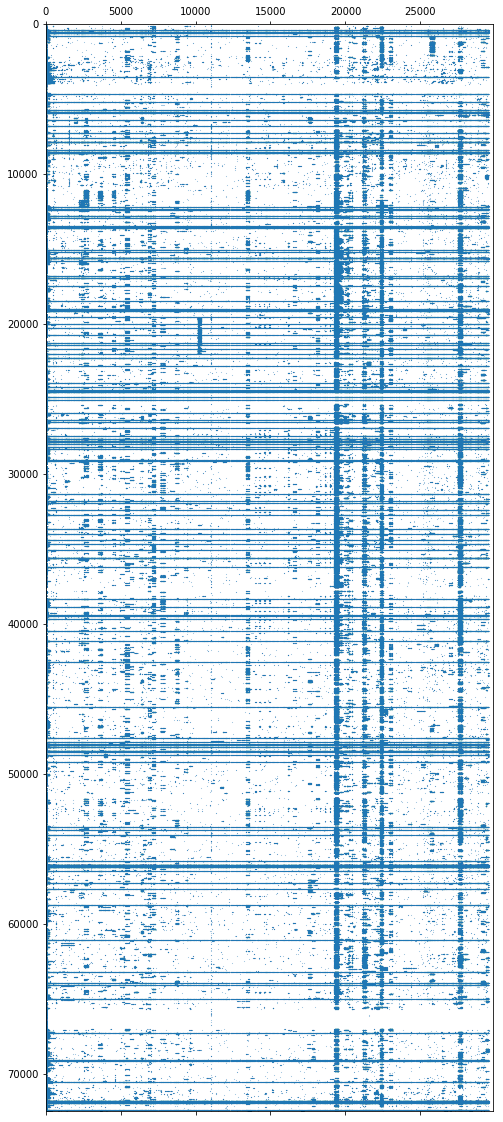

In [8]:
submat_coev = coevmat[: , nongap_cols ]
submat_aln = align_array[:,nongap_cols ]
plt.figure( figsize=(30,20))
plt.spy(submat_coev ,  markersize = .1)


In [9]:
#filter shitty rows?


In [10]:
qseq = b''.join(aln_row[nongap_cols])
qfile = 'covid_geno.fasta'
with open(qfile , 'w') as geno_out:
    geno_out.write((b'>testgeno\n'+qseq).decode())
    #print( (b'>testgeno\n'+qseq).decode())


In [12]:
import subprocess
import shlex
import pandas as pd 
#collapse codons
#use tblastn to map to prot

def runblastx( qseq , outannot = 'outannot.txt' , outfmt = None ):
    if outfmt is None:
        outfmt = [ 'qseqid' , 'sseqid' , 'qlen' ,  'slen' , 'qstart' , 'qend' ,  'qframe' , 'evalue' ]
        outfmt =  ' "10 ' + ''.join([fmt+ ' ' for fmt in outfmt]) + ' " '
        print(outfmt)
    args = 'blastx -query '+ qfile + ' -db covid_prots -outfmt' + outfmt + ' -out ' + outannot  
    p = subprocess.run( shlex.split(args) )
    return p , outannot
out = 'outannot.txt'
p,annot = runblastx(qfile  )

annotation = pd.read_csv( out , header = None )
annotation.columns = [ 'qseqid' , 'sseqid' , 'qlen' ,  'slen' , 'qstart' , 'qend' ,  'qframe' , 'evalue' ] 
annotation = annotation[ annotation['evalue'] < 10**-3 ]
print(annotation)
print(len(annotation), ' orfs detected')

#recluster codons
#load blast results into df

 "10 qseqid sseqid qlen slen qstart qend qframe evalue  " 
      qseqid          sseqid   qlen  slen  qstart   qend  qframe  \
0   testgeno  YP_009724389.1  29848  7096     244  13446       1   
1   testgeno  YP_009724389.1  29848  7096   13440  21530       3   
3   testgeno  YP_009725299.1  29848  1945    2698   8532       1   
7   testgeno  YP_009742610.1  29848  1945    2698   8532       1   
11  testgeno  YP_009724390.1  29848  1273   21574  25359       1   
13  testgeno  YP_009725307.1  29848   932   13440  16214       3   
14  testgeno  YP_009725298.1  29848   638     784   2697       1   
15  testgeno  YP_009742609.1  29848   638     784   2697       1   
16  testgeno  YP_009725308.1  29848   601   16215  18017       3   
17  testgeno  YP_009725309.1  29848   527   18018  19598       3   
18  testgeno  YP_009725300.1  29848   500    8533  10032       1   
19  testgeno  YP_009742611.1  29848   500    8533  10032       1   
20  testgeno  YP_009725310.1  29848   346   19599  20636 

In [13]:
#select longest nice hit
from Bio import Seq

rows = []
for ID in annotation.sseqid.unique():
    #print(annotation[annotation.sseqid == ID ].iloc[0])
    sub = annotation[annotation.sseqid == ID ]
    rows.append(sub.index[0] ) 
annotation = annotation.loc[rows]
print(len(annotation))
rows = []

for ID in annotation.qstart.unique():
    #print(annotation[annotation.sseqid == ID ].iloc[0])
    sub = annotation[annotation.qstart == ID ]
    rows.append(sub.index[0] )
annotation = annotation.loc[rows]
print(len(annotation))

genes =  {}
prots = {}

for i,r in annotation.iterrows():
    genes[i] = qseq[r.qstart-1:r.qend-1].decode()
    #print(genes[i])
    prots[i] = str(Seq.Seq( genes[i]).translate( ) )

    
annotation['prots'] = annotation.index.map(prots)
annotation['genes'] = annotation.index.map(genes)
print(annotation)


36
25
      qseqid          sseqid   qlen  slen  qstart   qend  qframe  \
0   testgeno  YP_009724389.1  29848  7096     244  13446       1   
3   testgeno  YP_009725299.1  29848  1945    2698   8532       1   
11  testgeno  YP_009724390.1  29848  1273   21574  25359       1   
13  testgeno  YP_009725307.1  29848   932   13440  16214       3   
14  testgeno  YP_009725298.1  29848   638     784   2697       1   
16  testgeno  YP_009725308.1  29848   601   16215  18017       3   
17  testgeno  YP_009725309.1  29848   527   18018  19598       3   
18  testgeno  YP_009725300.1  29848   500    8533  10032       1   
20  testgeno  YP_009725310.1  29848   346   19599  20636       3   
21  testgeno  YP_009724397.2  29848   419   28252  29508       1   
22  testgeno  YP_009725301.1  29848   306   10033  10950       1   
24  testgeno  YP_009725311.1  29848   298   20637  21530       3   
25  testgeno  YP_009724391.1  29848   275   25371  26195       3   
26  testgeno  YP_009725302.1  29848   290 

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/Seq.py:2715: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


In [16]:
import numpy as np
annotation = annotation[annotation.slen < 2000]
print(annotation)


aln_regions = np.array(list(zip(list(annotation.qstart),list(annotation.qend))))

#hackish 

aln_regions= aln_regions[1:,:]

aln_len = np.array(list( annotation.qend - annotation.qstart))
print(np.sum(aln_len) ) 

print(len(qseq))

      qseqid          sseqid   qlen  slen  qstart   qend  qframe  \
3   testgeno  YP_009725299.1  29848  1945    2698   8532       1   
11  testgeno  YP_009724390.1  29848  1273   21574  25359       1   
13  testgeno  YP_009725307.1  29848   932   13440  16214       3   
14  testgeno  YP_009725298.1  29848   638     784   2697       1   
16  testgeno  YP_009725308.1  29848   601   16215  18017       3   
17  testgeno  YP_009725309.1  29848   527   18018  19598       3   
18  testgeno  YP_009725300.1  29848   500    8533  10032       1   
20  testgeno  YP_009725310.1  29848   346   19599  20636       3   
21  testgeno  YP_009724397.2  29848   419   28252  29508       1   
22  testgeno  YP_009725301.1  29848   306   10033  10950       1   
24  testgeno  YP_009725311.1  29848   298   20637  21530       3   
25  testgeno  YP_009724391.1  29848   275   25371  26195       3   
26  testgeno  YP_009725302.1  29848   290   10951  11820       1   
28  testgeno  YP_009724393.1  29848   222   2650

In [15]:
print(annotation)

ValueError: Length of values does not match length of index

In [22]:
print( seq , 'toscsv')
annotation.to_csv('./gisaid/'+seq.replace('/', '_').replace('|','_')+'.csv')

hCoV-19/USA/MA-MGH-00701/2020|EPI ISL 460358|2020-04-06 toscsv


In [20]:
from scipy.sparse  import lil_matrix
#collapse codons

submat_coev = submat_coev.todense()

lenprots = sum ( [ len(prot) for prot in list(annotation.prots) ])


In [13]:
codonmat = np.zeros( (submat_coev.shape[0] , int(submat_coev.shape[1]/3) +1  ))
count = 0
print(codonmat.shape)
print(submat_coev.shape)

for i,r in annotation.iterrows():
    for codon in range(r.qstart-1, r.qend-1 , 3 ):
        cols = np.sum( submat_coev[:, codon:codon+3] , axis = 1 )
        codonmat[:,count] = cols.ravel()
        count+=1
        if count%500 == 0:
            print(count/lenprots)
#

(72513, 9950)
(72513, 29848)
0.05250997689561017
0.10501995379122034
0.1575299306868305
0.21003990758244068
0.26254988447805083
0.315059861373661
0.36756983826927114
0.42007981516488135
0.4725897920604915
0.5250997689561017
0.5776097458517119
0.630119722747322
0.6826296996429322
0.7351396765385423
0.7876496534341525
0.8401596303297627
0.8926696072253728
0.945179584120983
0.9976895610165931


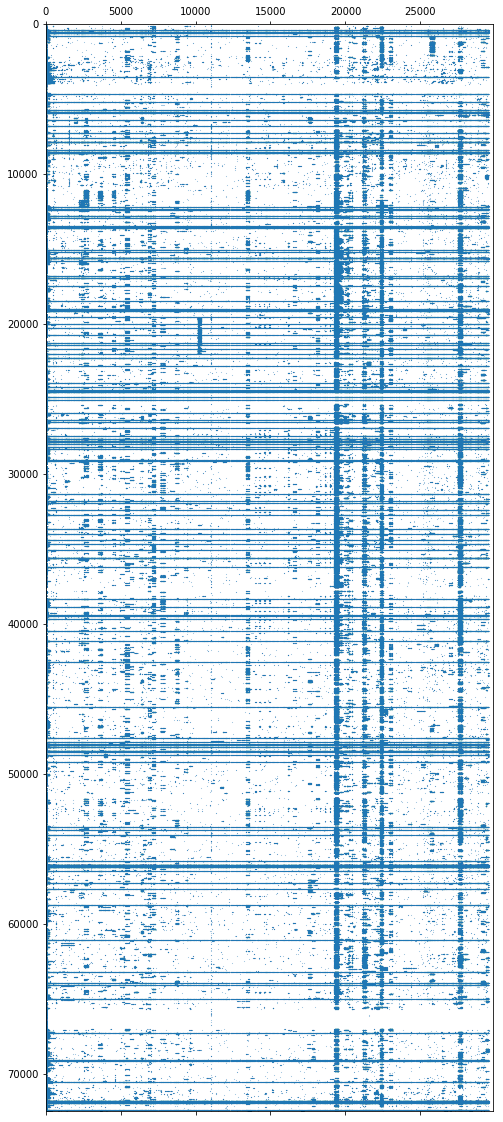

In [24]:
plt.figure( figsize=(30,20))
plt.spy(submat_coev , markersize = .1 )


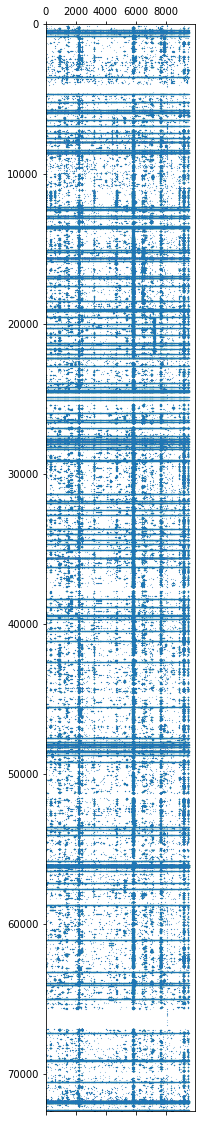

In [23]:
plt.figure( figsize=(30,20))
plt.spy(codonmat , markersize = .1 )


In [15]:
#use blurmat here
import dendropy
tree = dendropy.Tree.get(
    path='./lanford/ft_TBE.tree.txt',
    schema='newick')
for l in tree.leaf_nodes()[0:10]:
    print(str(l.taxon))
print(len(tree.leaf_nodes()))
print('leaves')
for i,n in enumerate(tree.nodes()):
    n.matrow = i
    
#blur w connectivity mat
blurfactor =  .5
bluriter = 4

connectmat = lil_matrix((len(tree.nodes()), len(tree.nodes() ) ) )

index = np.array([ [n.matrow, c.matrow ] for n in tree.nodes() for c in n.child_nodes()])
connectmat[index[:,0],index[:,1]] = 1
connectmat+= connectmat.T

'hCoV-19/Wuhan/WH04/2020|EPI ISL 406801|2020-01-05'
'hCoV-19/Xinyu/JX122/2020|EPI ISL 421249|2020-01-25'
'hCoV-19/Guangzhou/GZMU0046/2020|EPI ISL 429093|2020-02-08'
'hCoV-19/Wuhan/WHUH011/2020|EPI ISL 449484|2020-01-22'
'hCoV-19/Sichuan/SC-WCH3-255/2020|EPI ISL 451384|2020-01-27'
'hCoV-19/Guangzhou/GZMU0048/2020|EPI ISL 414691|2020-02-25'
'hCoV-19/Nanchang/JXN3T4/2020|EPI ISL 421246|2020-02-26'
'hCoV-19/Guangzhou/GZMU0078/2020|EPI ISL 457690|2020-02-11'
'hCoV-19/Ganzhou/JX81/2020|EPI ISL 421242|2020-01-25'
'hCoV-19/Shangrao/JX29/2020|EPI ISL 421244|2020-01-22'
36257
leaves


In [16]:
with open( 'connectmat.pkl' , 'wb') as connectout:
    connectout.write(pickle.dumps(connectmat))
    
    

In [19]:
connectmat = connectmat.todense()
np.fill_diagonal( connectmat , 1 )


In [18]:
with open( 'connectmat.pkl' , 'rb') as connectout:
    connectmat = pickle.loads(connectout.read())

    

In [20]:
import copy
blurmat = copy.deepcopy(codonmat)
print(connectmat.shape)
print(blurmat.shape)
for i in range( bluriter):
    blurmat += np.dot(blurfactor*connectmat , blurmat)
    print('blurring')
    print(i)

(72513, 72513)
(72513, 9950)
blurring
0
blurring
1
blurring
2
blurring
3


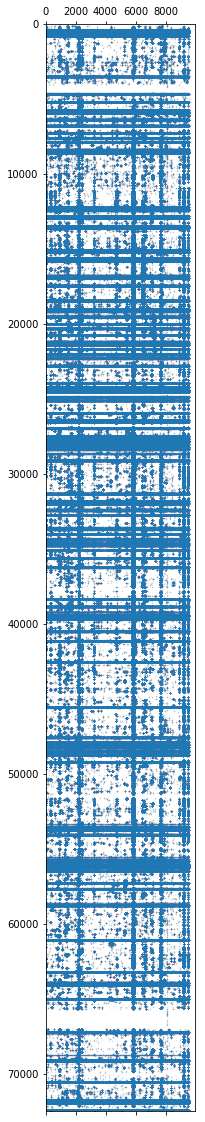

In [21]:
#cluster all v all at the codon level
plt.figure(figsize = ( 30,20))
plt.spy(blurmat,  markersize= .01)
#plt.show()

In [ ]:
import pickle


with open( 'blurmat_codons.pkl' , 'wb') as blurout:
    blurout.write(pickle.dumps(lil_matrix(blurmat) ))

In [1]:
import pickle
import numpy as np

with open( 'blurmat_codons.pkl' , 'rb') as blurout:
    blurmat = pickle.loads(blurout.read())
    
blurmat= blurmat.todense()


In [2]:
import h5py
import multiprocessing as mp
#calculate a distmat between cols w events
def distfun(stuff):
    i,j,v1,v2 = stuff
    #distance function between two continuous vectors
    #euclidean dist
    return (i,j,np.linalg.norm( v1-v2 ))
    
def process(q,retq, iolock):
    #calculate compression distances
    with iolock:
        print('init worker')
    from time import sleep
    while True:
        stuff = q.get()
        if stuff is None:
            break
        retq.put(distfun(stuff))
    print('done')

def mat_creator(retq,matsize,iolock):
    with iolock:
        print('init matcreator')
    #collect distances and create final mat
    calculations = (matsize**2 - matsize) / 2
    distmat = np.zeros((matsize,matsize))
    count = 0
    with h5py.File('./gisaid/alnEventdistmat.h5', 'w') as hf:
        try:
            hf.create_dataset("alnEventdists",  data=distmat)
        except:
            pass
        while True:
            r = retq.get()
            count+=1
            if r is None:
                break
            row,col,cdist = r
            hf['alnEventdists'][row,col] = cdist
            if count% 10000 == 0 :
                with iolock:
                    print(count/calculations)
                    print((row,col))
                hf.flush()
                    
    print('done saver')

startk = 0 
startl = 0

if __name__ == '__main__':
    
    NCORE = 60
    q = mp.Queue(maxsize=NCORE*5000)
    retq = mp.Queue(maxsize=NCORE*5000)
    iolock = mp.Lock()
    pool = mp.Pool(NCORE, initializer=process, initargs=(q,retq, iolock))
    p = mp.Process(target=mat_creator, args=(retq,blurmat.shape[1], iolock))
    p.start()
    
    for i in range(blurmat.shape[1]):
        for j in range(blurmat.shape[1]):
            if i < j :
                s1 = blurmat[:,i].ravel()
                s2 = blurmat[:,j].ravel()
                q.put( (i,j,s1,s2) )         
                if i % 500 == 0 and j % 500 == 0 :
                    print(i)
                    print(j)
                    
    for _ in range(NCORE):  # tell workers we're done
        q.put(None)
    retq.put(None)
    pool.close()
    pool.join()
    p.join()
    

init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init matcreator
0
500
0
1000
0
1500
0
2000
0
2500
0
3000
0
3500
0
4000
0
4500
0
5000
0
5500
0
6000
0
6500
0
7000
0
7500
0
8000
0
8500
0
9000
0
9500
0.00020203540569467096
(1, 52)


Process ForkPoolWorker-33:
Process ForkPoolWorker-45:
Process ForkPoolWorker-59:
Process ForkPoolWorker-47:
Process ForkPoolWorker-36:
Process ForkPoolWorker-41:
Process ForkPoolWorker-55:
Process ForkPoolWorker-20:
Process ForkPoolWorker-23:
Process ForkPoolWorker-51:
Process ForkPoolWorker-16:
Process ForkPoolWorker-26:
Process ForkPoolWorker-2:
Process ForkPoolWorker-35:
Process ForkPoolWorker-21:
Process ForkPoolWorker-44:
Process ForkPoolWorker-18:
Process ForkPoolWorker-49:
Process ForkPoolWorker-6:
Process ForkPoolWorker-39:
Process ForkPoolWorker-12:
Process ForkPoolWorker-1:
Process ForkPoolWorker-5:
Process ForkPoolWorker-50:
Process ForkPoolWorker-30:
Process ForkPoolWorker-13:
Process ForkPoolWorker-37:
Process Process-61:
Process ForkPoolWorker-11:
Process ForkPoolWorker-8:
Process ForkPoolWorker-48:
Process ForkPoolWorker-28:
Process ForkPoolWorker-22:
Process ForkPoolWorker-9:
Process ForkPoolWorker-4:
Process ForkPoolWorker-34:
Process ForkPoolWorker-14:
Process ForkPoo

KeyboardInterrupt: 

  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/pyth

init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
init worker
